In [1]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [2]:
resolution = 100
nfreq = 300
fcen = 1.75
df = 3.3

In [4]:

import numpy as np
import meep as mp
import nlopt
from typing import Tuple
import pickle

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.38, 0.72],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(csv_path)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf, E_sus, freq_range = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf, E_sus, freq_range
    
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # um
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf, E_sus, freq_range), f)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/mat/Material_merged.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/mat/Material_merged.csv"

eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path, num_lorentzians=2,  wl_range_nm = [0.38, 0.72])
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path, num_lorentzians=7)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path, num_lorentzians=5)

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Sio2/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/Al/mat/Material_merged_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/Refractive Index data/aNDP/mat/Material_merged_fit.pkl


In [5]:
sio2 =  mp.Medium(epsilon = eps_inf_sio2,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = eps_inf_andp,   E_susceptibilities = suscept_andp, valid_freq_range=freq_andp) # aNDP ,
Al  =   mp.Medium(epsilon = eps_inf_al,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)

In [6]:
### ----- Refractive index ----- ###,
# Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
# aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
# Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

Glass = sio2
aNDP = andp
Cathode = Al

# Cathode = mp.perfect_electric_conductor,
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(epsilon=CoverLayer_index**2) # SiN ,
ITO_m = mp.Medium(epsilon=ITO_m_index**2) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Absorber_layer = 0.5

boundary_layers = [
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.Low),  # 좌측 Absorber,
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.High), # 우측 Absorber,
    mp.Absorber(thickness=Absorber_layer, direction=mp.Y, side=mp.High), # 상단 Absorber,
    # mp.Absorber(thickness=0.25, direction=mp.Y, side=mp.Low), # 상단 Absorber,

]

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [25]:
cell_size = mp.Vector3(31, 2, 0)

geometry_fitting = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 0),
            material=Glass
        )
]

# center = -0.67
center = -0.68

source_center = mp.Vector3(0,center,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        
        # amplitude = 0.1
)]

In [26]:
# === 시뮬레이션 설정 === #
sim_fitting = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    extra_materials=[Cathode, aNDP, Glass]
)

     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     block, center = (0,-0.67,0)
          size (1e+20,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (1e+20,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     block, center = (0,-0.515,0)
          size (1e+20,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (1e+20,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (1e+20,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagon

<Axes: xlabel='X', ylabel='Y'>

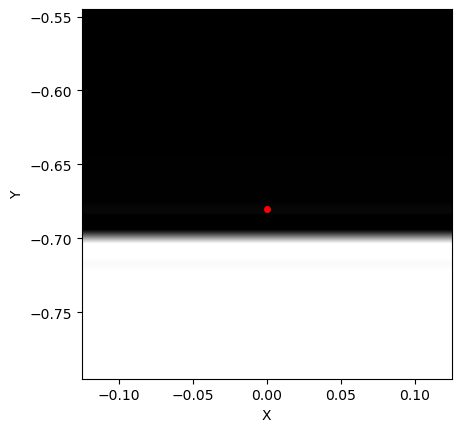

In [27]:
sim_fitting.plot2D(output_plane = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(0.25, 0.25, 0)))

In [28]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, center,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting = sim_fitting.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting.run(until = 50)
net_power_fitting = mp.get_fluxes(box_power_fitting)

-----------
Initializing structure...
time for choose_chunkdivision = 2.09808e-05 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     block, center = (0,-0.67,0)
          size (1e+20,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (1e+20,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     block, center = (0,-0.515,0)
          size (1e+20,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (1e+20,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3

/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/simulation.py:1660: RuntimeWarning: Note: your sources include frequencies outside the range of validity of the material models. This is fine as long as you eventually only look at outputs (fluxes, resonant modes, etc.) at valid frequencies.
  warnings.warn(warn_src, RuntimeWarning)


Meep progress: 1.035/50.0 = 2.1% done in 4.0s, 190.6s to go
on time step 207 (time=1.035), 0.0194639 s/step
Meep progress: 1.72/50.0 = 3.4% done in 8.0s, 225.5s to go
on time step 344 (time=1.72), 0.0292145 s/step
Meep progress: 2.41/50.0 = 4.8% done in 12.1s, 238.0s to go
on time step 482 (time=2.41), 0.0291446 s/step
Meep progress: 3.09/50.0 = 6.2% done in 16.1s, 244.0s to go
on time step 618 (time=3.09), 0.0295165 s/step
Meep progress: 3.77/50.0 = 7.5% done in 20.1s, 246.2s to go
on time step 754 (time=3.77), 0.0294504 s/step
Meep progress: 4.45/50.0 = 8.9% done in 24.1s, 246.4s to go
on time step 891 (time=4.455), 0.0294035 s/step
Meep progress: 5.14/50.0 = 10.3% done in 28.1s, 245.3s to go
on time step 1029 (time=5.145), 0.0291848 s/step
Meep progress: 5.83/50.0 = 11.7% done in 32.1s, 243.4s to go
on time step 1167 (time=5.835), 0.0291405 s/step
Meep progress: 6.865/50.0 = 13.7% done in 36.1s, 227.0s to go
on time step 1374 (time=6.87), 0.0193481 s/step
Meep progress: 7.555/50.0 =

### resolution 1000 - air(sourcepower)

In [29]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000123978 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.0462141 s
-----------
run 0 finished at t = 20.0 (4000 timesteps)
CSV 파일 저장 완료: sourcepower_res100.csv


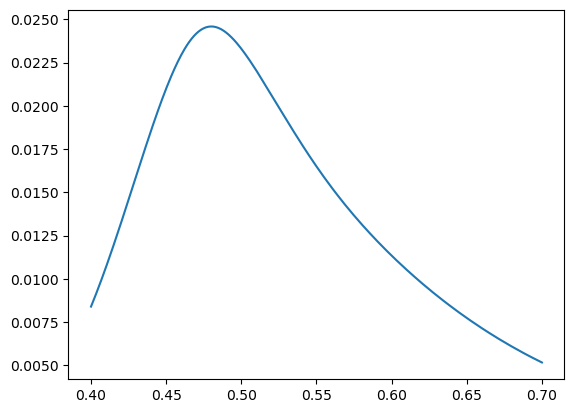

In [30]:
plt.plot(src_wavelengths, net_power_fitting)

In [31]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/al+alq3+andp/al_alq3_andp_100.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

In [21]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/nopatt.txt")

# CSV 파일 불러오기
no_pattern = np.genfromtxt(csv_path, delimiter=",")

no_pattern_func = no_pattern[:, 1]

In [22]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/box_method_nopatt.txt.29403")

# CSV 파일 불러오기
no_pattern_dipole = np.genfromtxt(csv_path, delimiter=",")

no_pattern_box = no_pattern_dipole[:, 1]

In [17]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/sourcepower_1000.csv")

# CSV 파일 불러오기
air_1000_data = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

air_1000 = air_1000_data[:, 1]

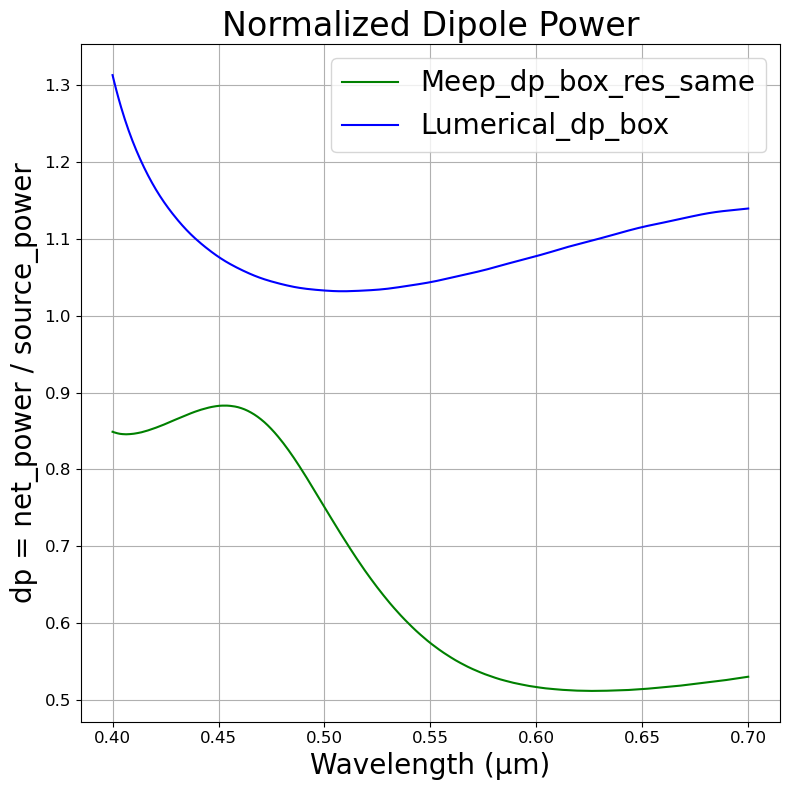

In [32]:
# dp_box / sourcepower 정규화
dp_fitting = np.array(net_power_fitting) / air_1000 
dp_fitting_100 = np.array(net_power_fitting) / src_power

wavelengths = 1 / np.array(mp.get_flux_freqs(box_power_fitting))

plt.figure(figsize=(8, 8))

# plot 순서
# plt.plot(wavelengths, dp_fitting, label='Meep_dp_box_res1000', color='red')
plt.plot(wavelengths, dp_fitting_100, label='Meep_dp_box_res_same', color='green')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelengths, no_pattern_func, label='no pattern func', color='purple')
# plt.plot(wavelengths, no_pattern_box, label='no pattern box', color='cyan')

# plt.plot(wavelength_sliced_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(loc='upper right', fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
# plt.xlim([0.4, 0.7])
plt.show()

In [ ]:
# dp_box / sourcepower 정규화
dp_fitting = np.array(net_power_fitting) / air_1000 
dp_fitting_100 = np.array(net_power_fitting) / src_power

wavelengths = 1 / np.array(mp.get_flux_freqs(box_power_fitting))

plt.figure(figsize=(8, 8))

# plot 순서
# plt.plot(wavelengths, dp_fitting, label='Meep_dp_box_res1000', color='red')
plt.plot(wavelengths, dp_fitting_100, label='Meep_dp_box_res_same', color='green')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelengths, no_pattern_func, label='no pattern func', color='purple')
# plt.plot(wavelengths, no_pattern_box, label='no pattern box', color='cyan')

# plt.plot(wavelength_sliced_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(loc='upper right', fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
# plt.xlim([0.4, 0.7])
plt.show()

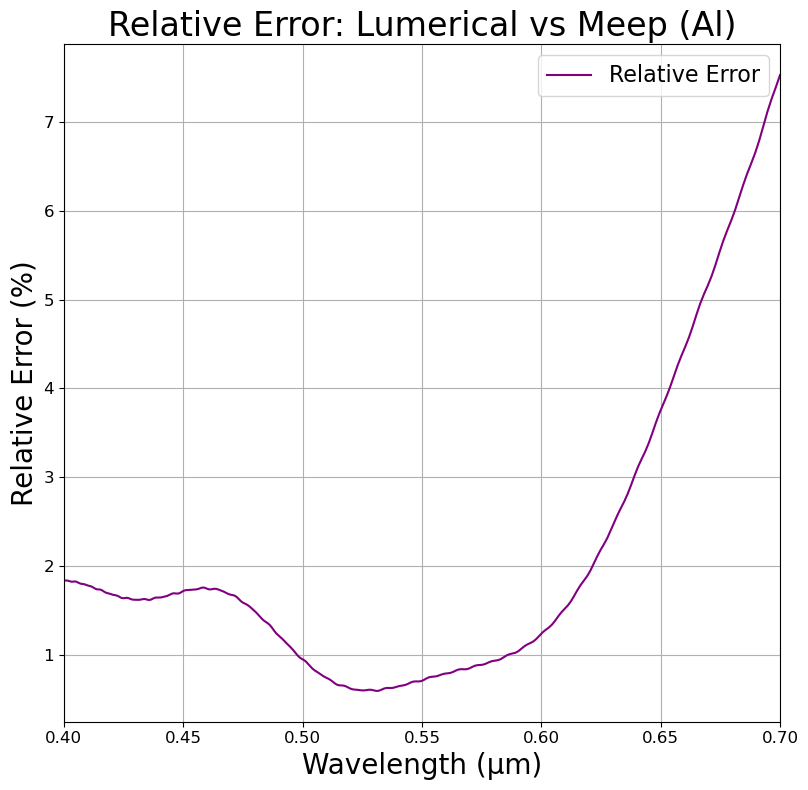

In [30]:
# === Relative Error 계산 === #
relative_error = np.abs((dp_fitting - lumerical) / lumerical)* 100

# relative_error_nofunc = np.abs((Al_power_sliced_nofunc - dp_fitting_al) / dp_fitting_al)* 100


# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
# plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_box', color='cyan')


# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error (%)", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (Al)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()
